<a href="https://colab.research.google.com/github/JustBartK/ProjektUBS/blob/main/UBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

import pandas as pd
from dataclasses import dataclass

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
class Market:

  def __init__(self, T, n, M, Q, r, sigma, S0, Strike):
    self.T = T   # Time to expiration
    self.n = n   # Number of points of discretization of a signle path
    self.M = M   # Number of simulated paths
    self.Q = Q   # Number of bundles
    self.P = int(M/Q)   # Number of paths in a single bundle
    self.r = r   # Risk-free rate
    self.S0 = S0 # Initial value of an underlying asset
    self.sigma = sigma
    self.Strike = Strike
# Tutaj można by dołożyć te czynniki dyskontujące d(k,t), ale może na razie do pominięcia, przyjmujemy stałą stopę wolną od ryzyka

  def BSDynamic(self):
    S = np.zeros((self.M, self.n))
    S[:, 0] = self.S0
    for i in range(self.M):
      for j in range(1, self.n):
        S[i, j] = S[i, j-1]*np.exp((self.r - 1/2 * self.sigma**2)*(self.T/(self.n-1)) + self.sigma * np.sqrt(self.T/(self.n-1)) * np.random.normal(0, 1))
    return S


@dataclass
class InterestRateSwap():

    fixed_rate: float
    expiry: float
    freq: float
    position: str
    notional: float

    def intrinsic_value(self, dynamic_sim: np.array, t: int):
        n = dynamic_sim.shape[1]
        if t == n-1:
            iv = self.cashflow(dynamic_sim, t)
        else:
            iv = dynamic_sim[:, t]*np.nan
        return iv

    def cashflow(self, dynamic_sim: np.array, t: int):

        n = dynamic_sim.shape[1]
        if t == 0:
            bpayment = 0.0
        elif (n - t - 1) % int((dynamic_sim.shape[1] - 1) / self.expiry / self.freq) == 0:
            bpayment = 1.0
        else:
            bpayment = 0.0

        rt = dynamic_sim[:, t]
        mult = 1.0 if self.position.lower() == "receiver" else -1.0
        cf = self.notional * mult * (rt - self.fixed_rate) / self.freq
        return cf*bpayment



class Tilley(Market):

  def __init__(self, T, n, M, Q, r, sigma, S0, Strike):
    super().__init__(T, n, M, Q, r, sigma, S0, Strike)

  def IntrinsicValuePut(self, Dynamic): #M , n może ładniej?
    D = np.copy(Dynamic)
    I = np.zeros((self.M, self.n))
    for i in range(self.M):  #po wierszach
      for j in range(self.n):  #po kolumnach
        I[i,j] = max(0, self.Strike - D[i,j])
    return I

  def SortDesc(self, sequence_to_sort_by): #, matrix
    order = np.argsort(-1*sequence_to_sort_by)
    return order

  def Value(self, Dynamic):
    V = np.zeros((self.M, self.n))
    H = np.zeros((self.M, self.n))
    Y = np.zeros((self.M, self.n))
    WykonWart = np.zeros(self.n)
    WykonWart[self.n - 1] = np.nan

    order = self.SortDesc(Dynamic[:, self.n - 1])

    Dynamic = Dynamic[order, :]
    I = self.IntrinsicValuePut(Dynamic)
    V[:, self.n - 1] = I[:, self.n - 1].copy()

    for i in range(self.n -2, -1 ,-1):  #zaczynamy od n-2 bo H jest jedno krótsze a V n-1 już jest policzone
      order = self.SortDesc(Dynamic[:, i])

      Dynamic = Dynamic[order, :]
      I = I[order, :]
      V = V[order, :]
      H = H[order, :]
      x = np.zeros(self.M)

      for j in range(self.Q):
        for k in range(j*self.P , (j + 1)*self.P):
          #liczenie V
          H[k, i] = np.exp(-self.r * self.T/(self.n-1)) * np.mean(V[j*self.P : (j + 1)*self.P, i + 1]) #pytanie jak z czasem / dyskontowanie
          if I[k, i] > H[k, i]:
            x[k] = 1
          else:
            x[k] = 0

      kgwiazdka = self.Boundary(x)
      if kgwiazdka >= self.M:
        WykonWart[i] = np.nan
      else:
        WykonWart[i] = Dynamic[kgwiazdka, i]

      Y[:, i] = np.concatenate((np.zeros(kgwiazdka), np.ones(self.M - kgwiazdka)), axis=0)
      V[:, i] = np.where(Y[:, i] == 1, I[:, i], H[:, i])


    return V, I, Y, WykonWart


  def Price(self, Dynamic):

    V, I, Y, _ = self.Value(Dynamic)
    Z = np.zeros((self.M, self.n))

    for i in range(self.M): #scieżka
      j = 0
      while Y[i,j] == 0 and j < self.n - 1:
        j += 1
      Z[i,j] = 1

    PremiumEstimator = 0
    for i in range(self.M):
      for j in range(self.n):
        PremiumEstimator += (Z[i, j]* I[i, j] * np.exp(- self.r * self.T * j / (self.n - 1)))/self.M

    V[:, 0] = PremiumEstimator
    return PremiumEstimator, V


  def ValueSwap(self, Dynamic, freq, position, notional):
    V = np.zeros((self.M, self.n))
    order = self.SortDesc(Dynamic[:, self.n - 1])
    Swap = InterestRateSwap(self.Strike, self.T, freq, position, notional)

    Dynamic = Dynamic[order, :]
    V[:, self.n - 1] = Swap.intrinsic_value(Dynamic, self.n - 1)

    for i in range(self.n -2, -1 ,-1):  #zaczynamy od n-2 bo H jest jedno krótsze a V n-1 już jest policzone
      order = self.SortDesc(Dynamic[:, i])
      Dynamic = Dynamic[order, :]
      V = V[order, :]
      x = np.zeros(self.M)

      for j in range(self.Q):
        for k in range(j*self.P , (j + 1)*self.P):
          V[k, i] = np.exp(-self.r * self.T/(self.n-1)) * np.mean(V[j*self.P : (j + 1)*self.P, i + 1])  + Swap.cashflow(Dynamic, i)[k]#pytanie jak z czasem / dyskontowanie

    V[:, 0] = np.mean(V[:, 0])
    return V

  def SwapPrice(self, Dynamic, freq, position, notional):
    V = self.ValueSwap(Dynamic, freq, position, notional)
    return np.mean(V[:, 0])



  def Boundary(self, vec):
    n = len(vec)
    i = 0
    candidates = [] #lista przechowująca pary (start, OnesLength) dla wszystkich ciągów jedynek

    #Znajdźmy wszystkie ciągi jedynek i ich pozycje startowe (nie wiem czy da się optymalniej xd)
    while i < n:
        if vec[i] == 1:
            start = i
            while i < n and vec[i] == 1:
                i += 1
            OnesLength = i - start
            candidates.append((start, OnesLength)) #doklejamy element na końcu listy (tak działa append)
        else:
            i += 1

    #Sprawdzamy po kolei dla każdego ciągu jedynek
    for start, OnesLength in candidates:
        ZerosLength = 0
        i = start + OnesLength
        while i < n:
          #dla ustaloneg ciągu 1 sprawdzamy wszystkie dalsze ciągi zer
            if vec[i] == 0:
                #praktycznie tak samo jak dla jedynek zliczamy
                ZerosStart = i
                while i < n and vec[i] == 0:
                    i += 1
                ZerosLength = i - ZerosStart
                if ZerosLength >= OnesLength:
                    break
            else:
                i += 1
        else:
            return start

    return n  #-1



In [ ]:
class Tsitsiklis(Market):

  def __init__(self, T, n, M, Q, r, sigma, S0, Strike): #Q
    super().__init__(T, n, M, Q, r, sigma, S0, Strike)

  def IntrinsicValuePut(self, Dynamic): #M , n może ładniej?
    D = np.copy(Dynamic)
    I = np.zeros((self.M, self.n))
    for i in range(self.M):  #po wierszach
      for j in range(self.n):  #po kolumnach
        I[i,j] = max(0, self.Strike - D[i,j])
    return I

  def AmericanPutOption(self, Dynamic):
    I = self.IntrinsicValuePut(Dynamic)
    S = np.copy(Dynamic)
    W = np.zeros((self.M, self.n))
    W[:, self.n - 1] = I[:, self.n - 1] #copy

    for i in range(self.n - 2, 0, -1):
      Czy = np.where(I[:, i ] > 0, True, False)
      x = S[Czy, i].reshape(-1,1)

      if len(x):
        y = I[Czy, i + 1] * np.exp(-self.r *self.T / (self.n - 1))
        y = y.reshape(-1,1)
        degree = 3  # Degree of the polynomial  #6
        poly_features = PolynomialFeatures(degree=degree)
        x_poly = poly_features.fit_transform(x)

        model = LinearRegression()
        model.fit(x_poly, y)

        y_pred = model.predict(x_poly).ravel()
        y_pred2 = np.zeros(self.M)
        l = 0
        for k in range(self.M):
          if Czy[k]:
            y_pred2[k] = y_pred[l]
            l += 1
          else:
            y_pred2[k] = 0

        for j in range(self.M):
          if Czy[j]:
            if I[j, i] > y_pred2[j]:
              W[j, i] = I[j, i]
              for l in range(self.n - 1, i, -1):  #zerowanie poprzeniego el?
                W[j, l] = 0
            else:
              W[j, i] = 0
          else:
            W[j, i] = 0

    price = 0
    for i in range(self.M):
      for j in range(1, self.n):
        if W[i,j]!=0:
          price += (W[i, j] * np.exp(-self.r * self.T * j / (self.n - 1))) / self.M

    return price

  def SwapPrice(self, Dynamic, freq, position, notional):

    S = np.copy(Dynamic)
    W = np.zeros((self.M, self.n))
    Swap = InterestRateSwap(self.Strike, self.T, freq, position, notional)
    W[:, self.n - 1] = Swap.intrinsic_value(S, self.n - 1)


    for i in range(self.n - 2, 0, -1):
      x = S[:, i].ravel().reshape(-1,1)
      y = W[:, i + 1] * np.exp(-self.r *self.T / (self.n - 1)) + Swap.cashflow(S, i)
      y = y.ravel().reshape(-1,1)
      degree = 3  # Degree of the polynomial  #6
      poly_features = PolynomialFeatures(degree=degree)
      x_poly = poly_features.fit_transform(x)

      model = LinearRegression()
      model.fit(x_poly, y)

      y_pred = model.predict(x_poly).ravel()
      W[:, i] = y_pred

    price = np.mean(W[:, 1]) * np.exp(-self.r *self.T / (self.n - 1))
    W[:, 0] = price

    return price, W




  def AmericanPutOptionMod(self, Dynamic):
    I = self.IntrinsicValuePut(Dynamic)
    S = np.copy(Dynamic)
    W = np.zeros((self.M, self.n))
    W[:, self.n - 1] = I[:, self.n - 1] #copy

    for i in range(self.n - 2, -1, -1):
      x = S[:, i].ravel().reshape(-1,1)
      y = W[:, i + 1] * np.exp(-self.r *self.T / (self.n - 1))
      y = y.ravel().reshape(-1,1)

      degree = 3  # Degree of the polynomial  #6
      poly_features = PolynomialFeatures(degree=degree)
      x_poly = poly_features.fit_transform(x)

      model = LinearRegression()
      model.fit(x_poly, y)

      y_pred = model.predict(x_poly).ravel()

      W[:, i] = np.maximum(I[:,i], y_pred)

    W[:, 0] = np.mean(W[:, 1]) * np.exp(-self.r *self.T / (self.n - 1))
    return W[0,0], W

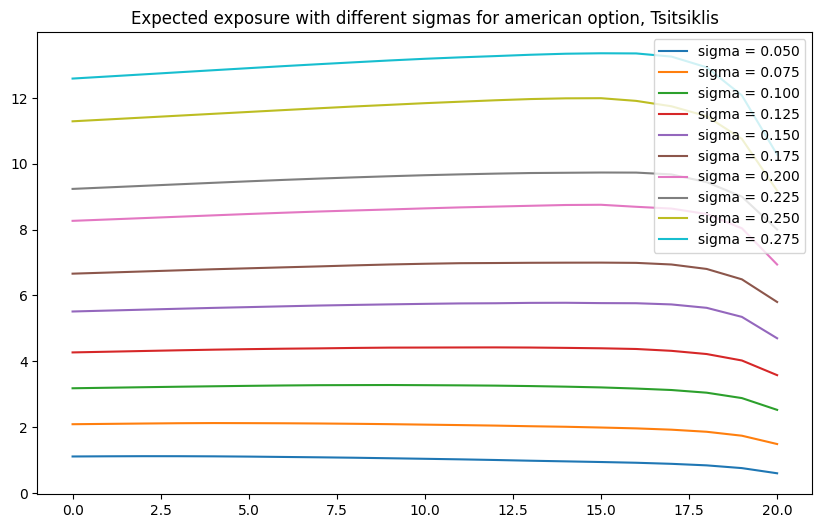

In [ ]:
Sig = np.linspace(0.05, 0.275, 10)
def RysExposureSigmasTsitsiklis(Sig = Sig, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040*4, Q = 80*2,  Strike = 0.05 ):
  plt.figure(figsize = (10,6))
  for sigma in Sig:
    Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()
    p, W = Tsitsiklis(T, n, M, Q, r, sigma, S0, Strike).AmericanPutOptionMod(Dynamic)
    V1 = np.zeros(n)

    # _, W2 = Tilley(T, n, M, Q, r, sigma, S0, Strike).Price(Dynamic)
    # V2 = np.zeros(n)

    for i in range(n):
      V1[i] = np.mean(W[:, i])*1000 #nominale
    plt.plot(V1, label = f"sigma = {sigma:.3f}")
  plt.title("Expected exposure with different sigmas for american option, Tsitsiklis")
  plt.legend()
  plt.show()
RysExposureSigmasTsitsiklis()

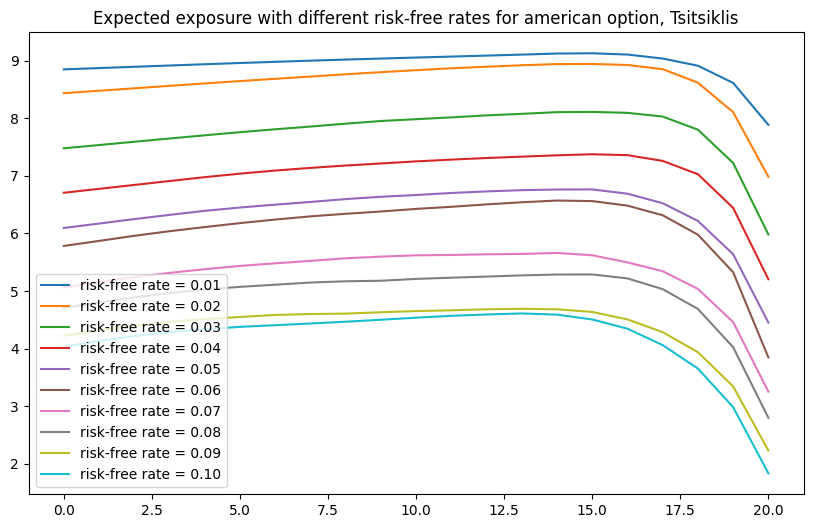

In [ ]:
R = np.linspace(0.01, 0.1, 10)
def RysExposureRatesTsitsiklis(sigma = 0.2, R = R, T = 5.0, S0 = 0.05, n = 21, M = 5040*4, Q = 80*2,  Strike = 0.05 ):
  plt.figure(figsize = (10,6))
  for r in R:
    Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()
    p, W = Tsitsiklis(T, n, M, Q, r, sigma, S0, Strike).AmericanPutOptionMod(Dynamic)
    V1 = np.zeros(n)

    # _, W2 = Tilley(T, n, M, Q, r, sigma, S0, Strike).Price(Dynamic)
    # V2 = np.zeros(n)

    for i in range(n):
      V1[i] = np.mean(W[:, i])*1000 #nominale
    plt.plot(V1, label = f"risk-free rate = {r:.2f}")
  plt.title("Expected exposure with different risk-free rates for american option, Tsitsiklis")
  plt.legend(loc = "lower left")
  plt.show()
RysExposureRatesTsitsiklis()

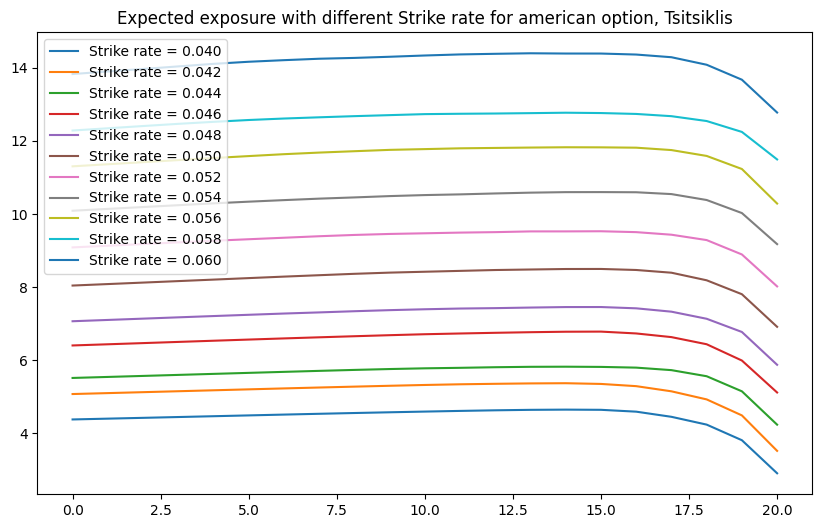

In [ ]:
STRIKE = np.linspace(0.04, 0.06, 11)
def RysExposureStrikesTsitsiklis(sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040*4, Q = 80*2,  STRIKE = STRIKE ):
  plt.figure(figsize = (10,6))
  for Strike in STRIKE:
    Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()
    p, W = Tsitsiklis(T, n, M, Q, r, sigma, S0, Strike).AmericanPutOptionMod(Dynamic)
    V1 = np.zeros(n)

    # _, W2 = Tilley(T, n, M, Q, r, sigma, S0, Strike).Price(Dynamic)
    # V2 = np.zeros(n)

    for i in range(n):
      V1[i] = np.mean(W[:, i])*1000 #nominale
    plt.plot(V1, label = f"Strike rate = {Strike:.3f}")
  plt.title("Expected exposure with different Strike rate for american option, Tsitsiklis")
  plt.legend()
  plt.show()
RysExposureStrikesTsitsiklis()

In [ ]:
def RysExposure(sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040*4, Q = 80*2,  Strike = 0.05 ):

  Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()
  p, W = Tsitsiklis(T, n, M, Q, r, sigma, S0, Strike).AmericanPutOptionMod(Dynamic)
  V1 = np.zeros(n)

  _, W2 = Tilley(T, n, M, Q, r, sigma, S0, Strike).Price(Dynamic)
  V2 = np.zeros(n)

  for i in range(n):
    V1[i] = np.mean(W[:, i])*1000 #nominale
    V2[i] = np.mean(W2[:, i])*1000
  plt.figure(figsize = (10,6))
  plt.plot(V1, label = "Expected Exposure American Put, Tsitsiklis", color = "red")
  plt.plot(V2, label = "Expected Exposure American Put, Tilley")
  plt.legend()
  plt.show()



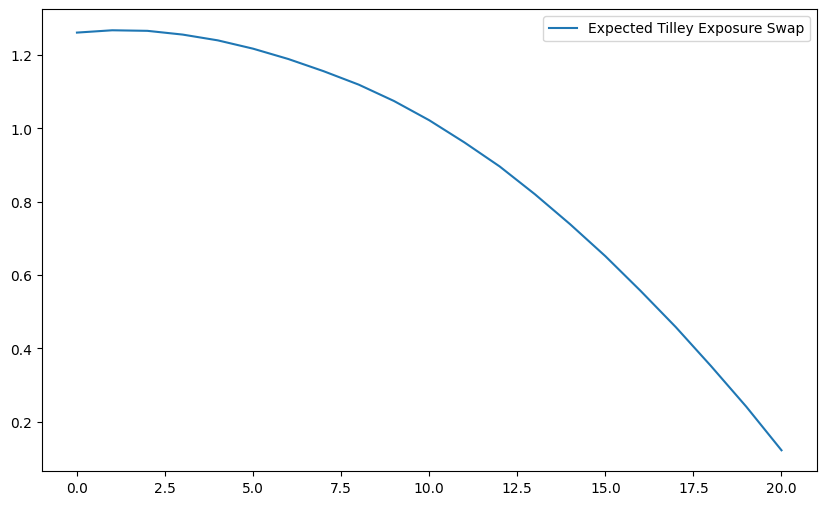

In [ ]:
def RysTilleyExposureSwap(sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040, Strike = 0.05):
  Dynamic = Market(T, n, M, 1, r, sigma, S0, Strike).BSDynamic()
  W = Tilley(T, n, M, 1, r, sigma, S0, Strike).ValueSwap(Dynamic, 4, "receiver", 100)
  V1 = np.zeros(n)
  for i in range(n):
    V1[i] = np.mean(W[:, i]) #nominale
  plt.figure(figsize = (10,6))
  plt.plot(V1, label = "Expected Tilley Exposure Swap")
  plt.legend()
  plt.show()
RysTilleyExposureSwap()

In [ ]:
def RysCenWyk(sigma = 0.2, r = 0.01, T = 5.0, S0 = 0.05, n = 21, M = 1000):

  Dynamic = Market(T, n, M, 1, r, sigma, S0, 0.05).BSDynamic()
  _, _, _, WykonWart = Tilley(T, n, M, 1, r, sigma, S0, 0.05).Value(Dynamic)

  df = pd.DataFrame( WykonWart,
                    columns=["Early Excercise Boundary"],
                              index=np.linspace(0, T, Dynamic.shape[1]))
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(df.index, Dynamic.T, color='grey', alpha=0.4)
  df.plot(ax=ax, colormap='plasma')
  ax.set_ylabel('$r_t$')
  ax.set_xlabel('$t$')


  plt.show(fig)

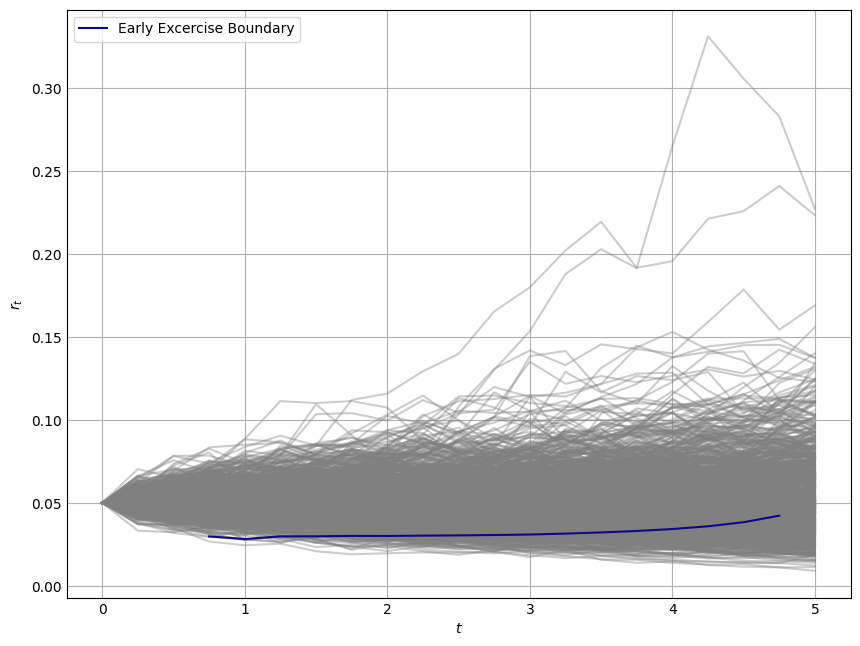

In [ ]:
RysCenWyk()

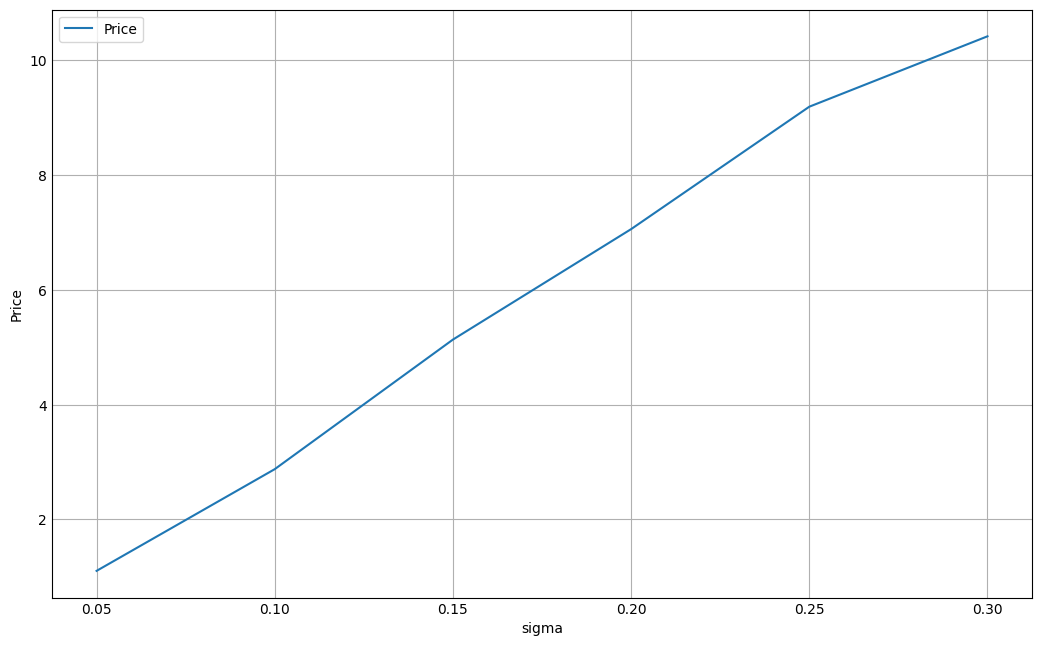

In [ ]:
SIG = [i*5/100 for i in range(1,7)]
def RysunekTilleySigma(SIG = SIG, r = 0.01, T = 5.0, S0 = 0.05, n = 21, M = 5040, Q = 80, Strike = 0.05):
    #domyślnie dla 1 pln, więc *1000 albo *100?
  Price = np.zeros(len(SIG))
  i = 0

  for sigma in SIG:
    Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()
    Price[i] = Tilley(T, n, M, Q, r, sigma, S0, Strike).Price(Dynamic)*1000
    i += 1

  plt.figure(figsize = (10,6))
  plt.plot(SIG, Price, label = "Price")
  plt.legend()
  plt.xlabel('sigma')
  plt.ylabel('Price')
  plt.show()

RysunekTilleySigma()

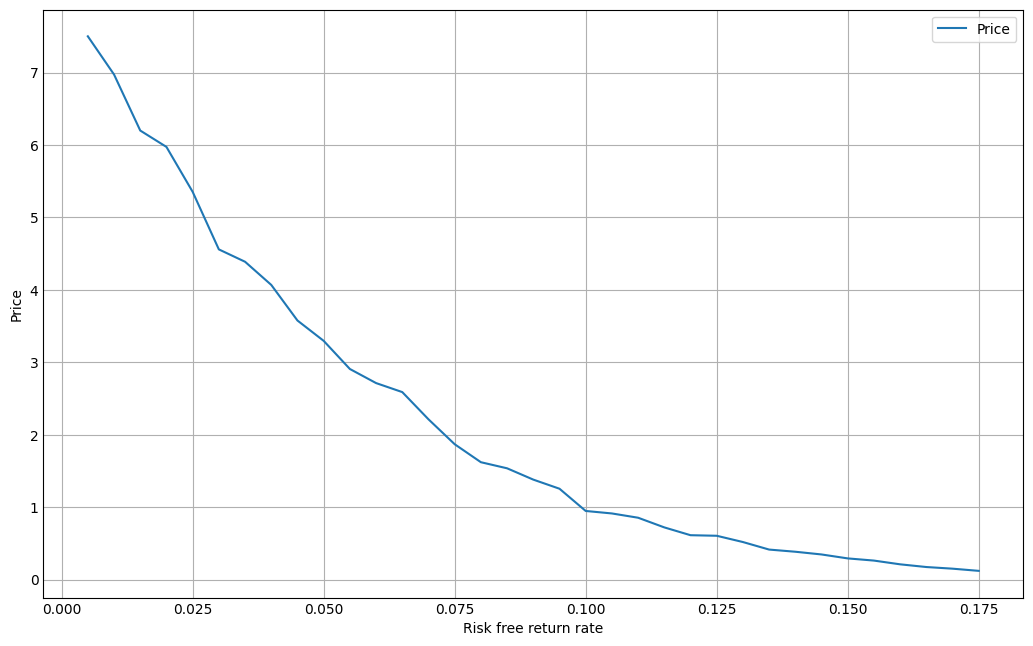

In [ ]:
Rrange = [i*1/200 for i in range(1,36)]
def RysunekTilleyReturnRate(Rrange = Rrange, T = 5.0, sigma = 0.2, S0 = 0.05, n = 21, M = 5040, Q = 80, Strike = 0.05):
    #domyślnie dla 1 pln, więc *1000 albo *100?
  Price = np.zeros(len(Rrange))
  i = 0

  for r in Rrange:
    Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()
    Price[i] = Tilley(T, n, M, Q, r, sigma, S0, Strike).Price(Dynamic)*1000
    i += 1

  plt.figure(figsize = (10,6))
  plt.plot(Rrange, Price, label = "Price")
  plt.legend()
  plt.xlabel('Risk free return rate')
  plt.ylabel('Price')
  plt.show()

RysunekTilleyReturnRate()

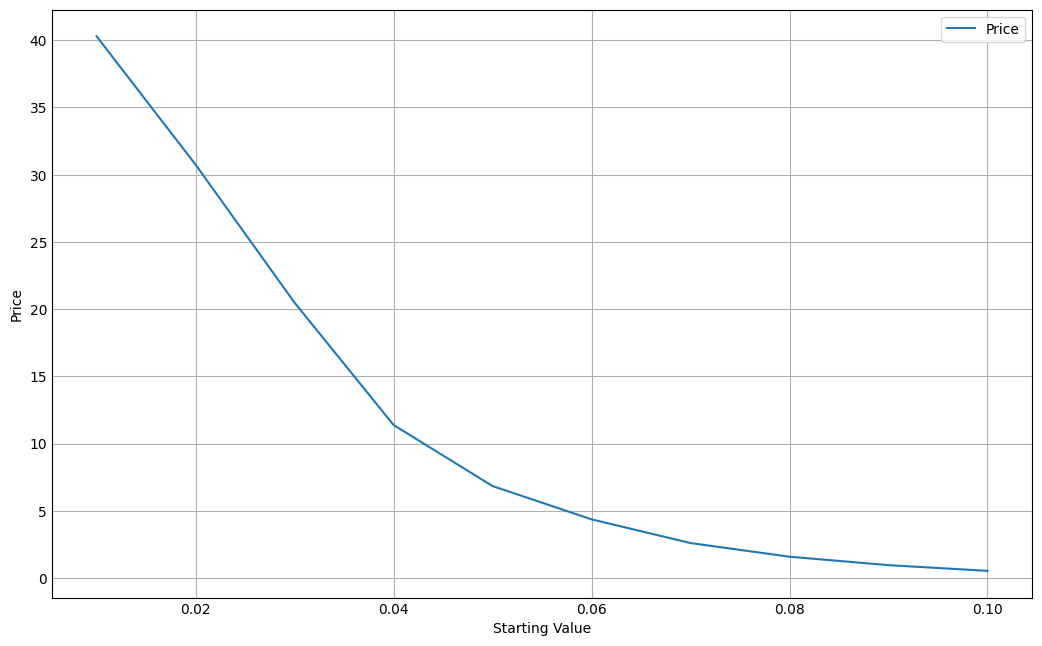

In [ ]:
SZero = [i*1/100 for i in range(1,11)]
def RysunekTilleyS( T = 5.0, sigma = 0.2, r = 0.01, SZero = SZero, n = 21, M = 5040, Q = 80, Strike = 0.05):
    #domyślnie dla 1 pln, więc *1000 albo *100?
  Price = np.zeros(len(SZero))
  i = 0

  for S0 in SZero:
    Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()
    Price[i] = Tilley(T, n, M, Q, r, sigma, S0, Strike).Price(Dynamic)*1000
    i += 1

  plt.figure(figsize = (10,6))
  plt.plot(SZero, Price, label = "Price")
  plt.legend()
  plt.xlabel('Starting Value')
  plt.ylabel('Price')
  plt.show()

RysunekTilleyS()

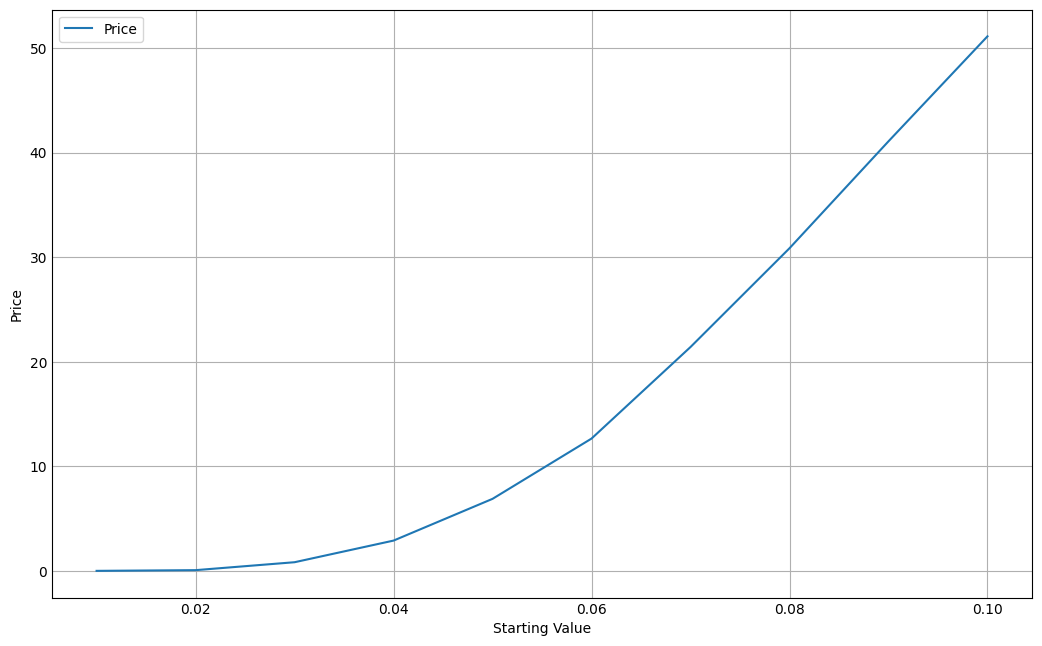

In [ ]:
StrikeK = [i*1/100 for i in range(1,11)]
def RysunekTilleyK( T = 5.0, sigma = 0.2, r = 0.01, S0 = 0.05, n = 21, M = 5040, Q = 80, Strikek = StrikeK):
    #domyślnie dla 1 pln, więc *1000 albo *100?
  Price = np.zeros(len(StrikeK))
  i = 0

  for Strike in StrikeK:
    Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()
    Price[i] = Tilley(T, n, M, Q, r, sigma, S0, Strike).Price(Dynamic)*1000
    i += 1

  plt.figure(figsize = (10,6))
  plt.plot(StrikeK, Price, label = "Price")
  plt.legend()
  plt.xlabel('Starting Value')
  plt.ylabel('Price')
  plt.show()

RysunekTilleyK()

In [ ]:
def Rysunek(sigma = 0.2, r = 0.01, T = 5.0, S0 = 0.05, n = 21, M = 1000):

  rf_sim = Market(T, n, M, 1, r, sigma, S0, 100).BSDynamic()

  qs = [0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975]
  df_quantiles = pd.DataFrame(np.quantile(rf_sim, qs, axis=0).T,
                              columns=['$q_{' + f'{q:.3f}' + "}$" for q in qs],
                              index=np.linspace(0, T, rf_sim.shape[1]))
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(df_quantiles.index, rf_sim.T, color='grey', alpha=0.4)
  df_quantiles.plot(ax=ax, colormap='inferno')
  ax.set_ylabel('$r_t$')
  ax.set_xlabel('$t$')


  plt.show(fig)


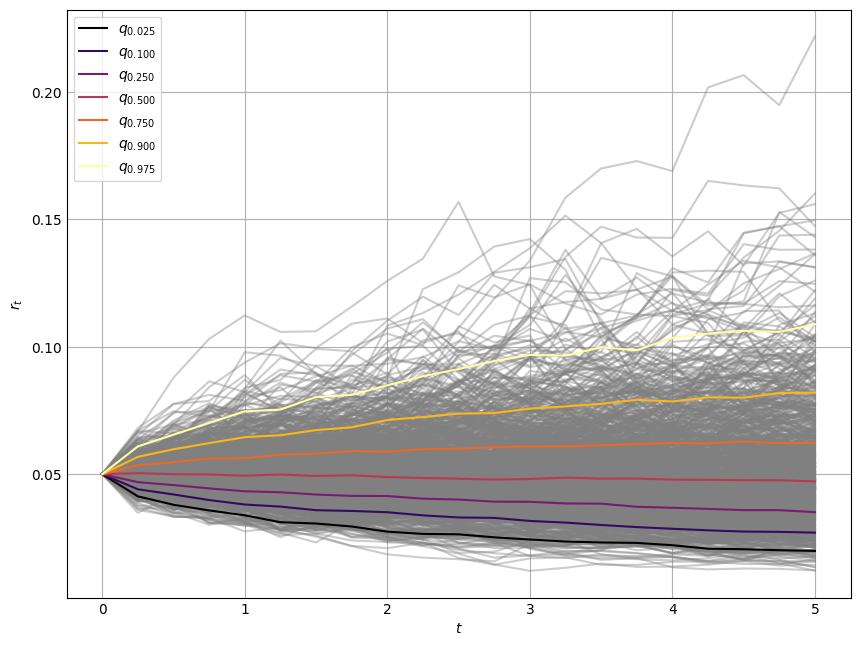

In [ ]:
Rysunek0 = Rysunek()
Rysunek0

In [ ]:
Tilley(1,10,1000,40,0.03,0.2,0.03,0.05).SwapPrice(Market(1,10,1000,40,0.03,0.2,0.03, 0.05).BSDynamic(), 4, "receiver", 100)

-2.416631191607884

In [ ]:
Tilley(1,10,1600,40,0.03,0.2,100,100).Price(Market(1,10,1600,40,0.03,0.2,100,100).BSDynamic())

85.67481220725337 1306 8
87.68815926277104 1280 7
84.6644040230999 1389 6
87.046986388291 1347 5
87.91000836551936 1360 4
76.4734684023076 1586 3
80.49026727082105 1583 2
83.28051938386577 1596 1
nan 1600 0


5.825887396128938

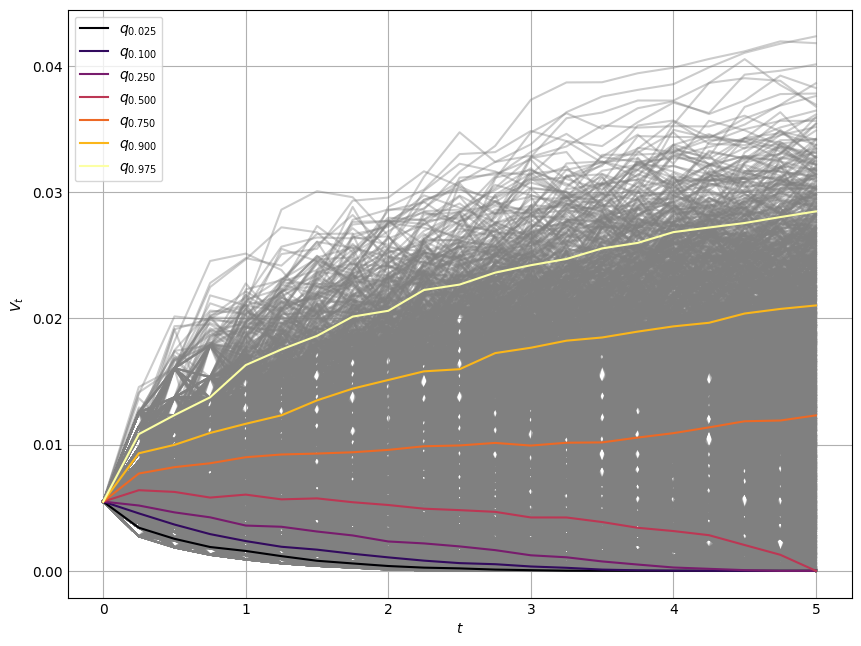

In [ ]:
def RysKwantylTilley(sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040, Strike = 0.05, Q = 80):

  Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()

  p, W2 = Tilley(T, n, M, Q, r, sigma, S0, Strike).Price(Dynamic)

  qs = [0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975]
  df_quantiles = pd.DataFrame(np.quantile(W2, qs, axis=0).T,
                              columns=['$q_{' + f'{q:.3f}' + "}$" for q in qs],
                              index=np.linspace(0, T, W2.shape[1]))
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(df_quantiles.index, W2.T, color='grey', alpha=0.4)
  df_quantiles.plot(ax=ax, colormap='inferno')
  ax.set_ylabel('$V_t$')
  ax.set_xlabel('$t$')


  plt.show(fig)

RysKwantylTilley()

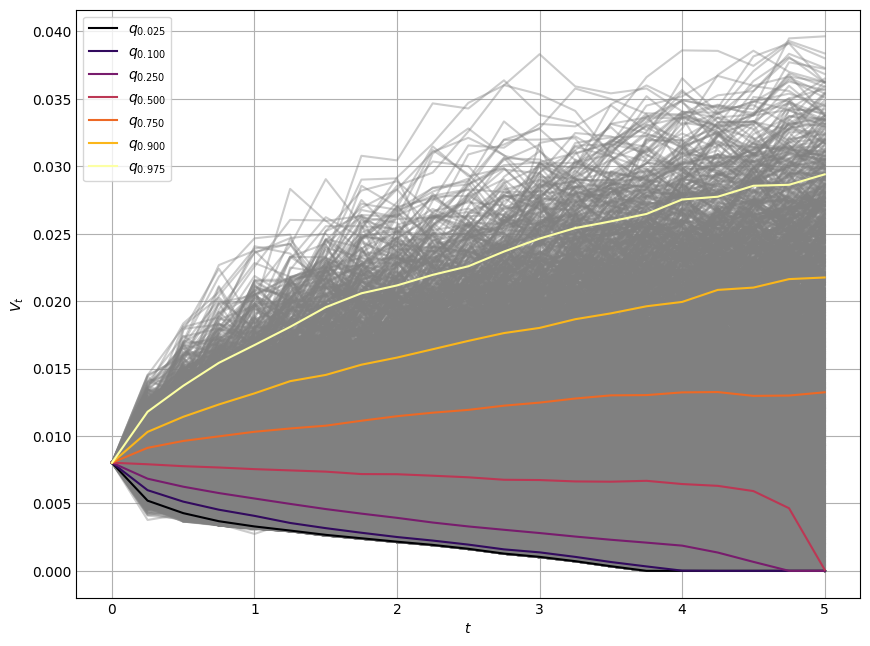

In [ ]:
def RysKwantylTsitsiklis(sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040, Strike = 0.05, Q = 80):

  Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()

  p, W2 = Tsitsiklis(T, n, M, Q, r, sigma, S0, Strike).AmericanPutOptionMod(Dynamic)

  qs = [0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975]
  df_quantiles = pd.DataFrame(np.quantile(W2, qs, axis=0).T,
                              columns=['$q_{' + f'{q:.3f}' + "}$" for q in qs],
                              index=np.linspace(0, T, W2.shape[1]))
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(df_quantiles.index, W2.T, color='grey', alpha=0.4)
  df_quantiles.plot(ax=ax, colormap='inferno')
  ax.set_ylabel('$V_t$')
  ax.set_xlabel('$t$')


  plt.show(fig)

RysKwantylTsitsiklis()

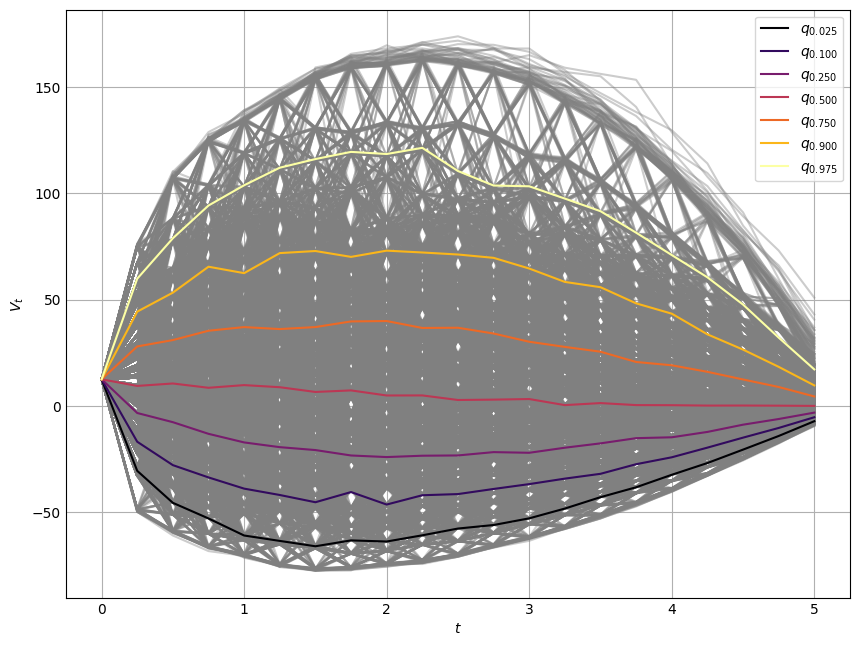

In [ ]:
def RysSwapKwantylTilley(sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040, Strike = 0.05, Q = 80):

  Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()

  W2 = Tilley(T, n, M, Q, r, sigma, S0, Strike).ValueSwap(Dynamic, 4, "receiver", 1000)

  qs = [0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975]
  df_quantiles = pd.DataFrame(np.quantile(W2, qs, axis=0).T,
                              columns=['$q_{' + f'{q:.3f}' + "}$" for q in qs],
                              index=np.linspace(0, T, W2.shape[1]))
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(df_quantiles.index, W2.T, color='grey', alpha=0.4)
  df_quantiles.plot(ax=ax, colormap='inferno')
  ax.set_ylabel('$V_t$')
  ax.set_xlabel('$t$')


  plt.show(fig)

RysSwapKwantylTilley()

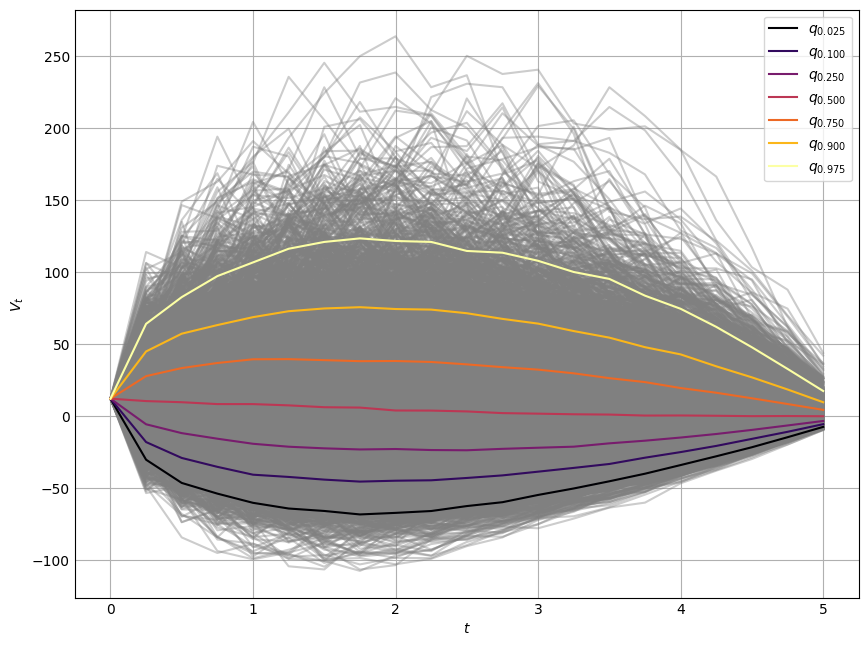

In [ ]:
def RysSwapKwantylTsitsiklis(sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040, Strike = 0.05, Q = 80):

  Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()

  _, W = Tsitsiklis(T, n, M, Q, r, sigma, S0, Strike).SwapPrice(Dynamic, 4, "receiver", 1000)

  qs = [0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975]
  df_quantiles = pd.DataFrame(np.quantile(W, qs, axis=0).T,
                              columns=['$q_{' + f'{q:.3f}' + "}$" for q in qs],
                              index=np.linspace(0, T, W.shape[1]))
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(df_quantiles.index, W.T, color='grey', alpha=0.4)
  df_quantiles.plot(ax=ax, colormap='inferno')
  ax.set_ylabel('$V_t$')
  ax.set_xlabel('$t$')


  plt.show(fig)

RysSwapKwantylTsitsiklis()

In [ ]:
def SwapPrice(sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040, Strike = 0.05, Q = 80):

  Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()
  p1, W = Tsitsiklis(T, n, M, Q, r, sigma, S0, Strike).SwapPrice(Dynamic, 4, "receiver", 1000)
  W2 = Tilley(T, n, M, Q, r, sigma, S0, Strike).ValueSwap(Dynamic, 4, "receiver", 1000)

  print(np.mean(W[:,15]))
  print(np.mean(W2[:,15]))

SwapPrice()

14.910847068760049
14.910847068760276


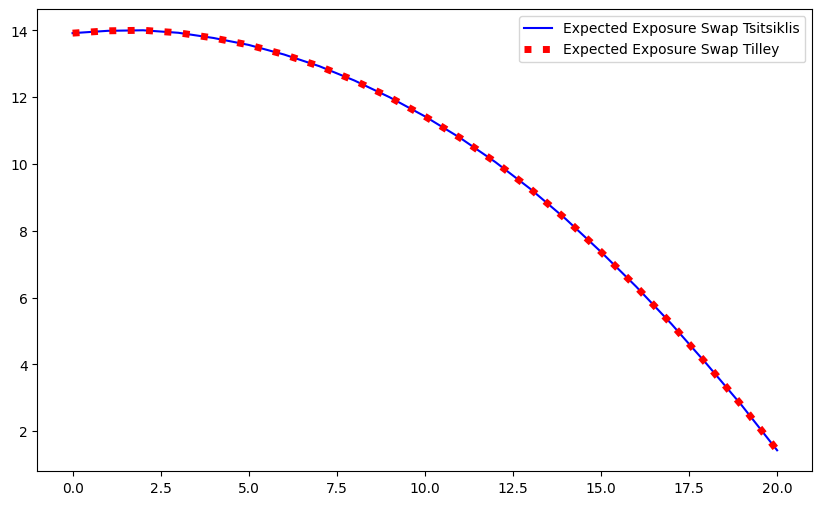

In [ ]:
def RysSwapExposure(sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040, Strike = 0.05, Q = 80):
  Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()
  p, W = Tsitsiklis(T, n, M, Q, r, sigma, S0, Strike).SwapPrice(Dynamic, 4, "receiver", 1000)
  V1 = np.zeros(n)

  W2 = Tilley(T, n, M, Q, r, sigma, S0, Strike).ValueSwap(Dynamic, 4, "receiver", 1000)
  V2 = np.zeros(n)

  for i in range(n):
    V1[i] = np.mean(W[:, i])
    V2[i] = np.mean(W2[:, i])
  plt.figure(figsize = (10,6))
  plt.plot(V1, label = "Expected Exposure Swap Tsitsiklis", color = 'blue')
  plt.plot(V2, label = "Expected Exposure Swap Tilley", color = 'red',linewidth = 5, linestyle = ":")
  plt.legend()
  plt.show()

RysSwapExposure()

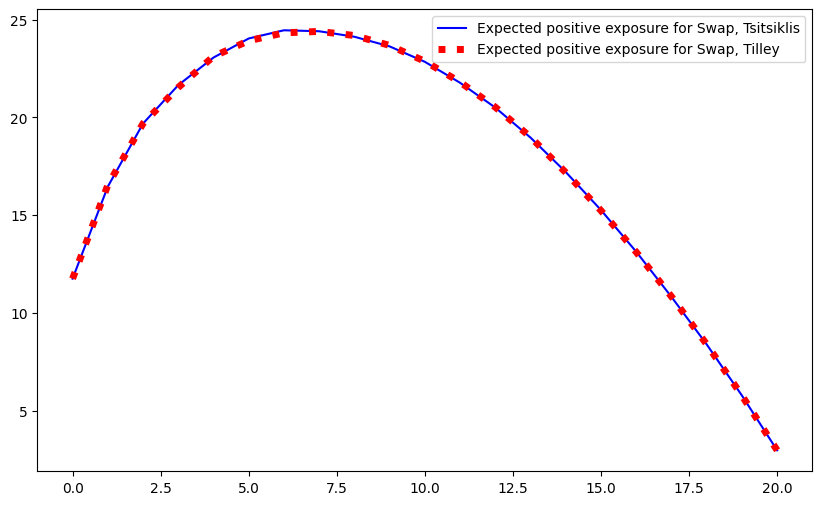

In [ ]:
def RysSwapEPE(sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040, Strike = 0.05, Q = 80):
  Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()
  p, W = Tsitsiklis(T, n, M, Q, r, sigma, S0, Strike).SwapPrice(Dynamic, 4, "receiver", 1000)
  V1 = np.zeros(n)

  W2 = Tilley(T, n, M, Q, r, sigma, S0, Strike).ValueSwap(Dynamic, 4, "receiver", 1000)
  V2 = np.zeros(n)

  for i in range(n):
    V1[i] = np.mean(np.maximum(W[:, i], 0))
    V2[i] = np.mean(np.maximum(W2[:, i], 0))
  plt.figure(figsize = (10,6))
  plt.plot(V1, label = "Expected positive exposure for Swap, Tsitsiklis", color = 'blue')
  plt.plot(V2, label = "Expected positive exposure for Swap, Tilley", color = 'red',linewidth = 5, linestyle = ":")
  plt.legend()
  plt.show()

RysSwapEPE()

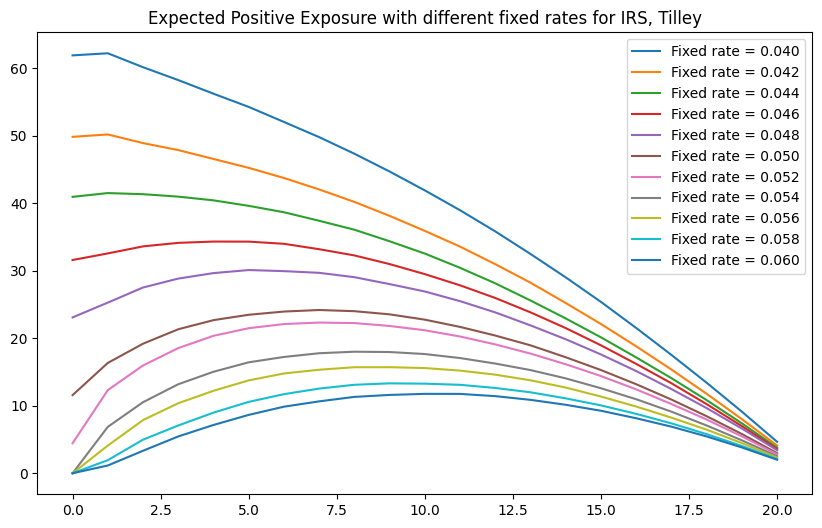

In [ ]:
STRIKE = np.linspace(0.04, 0.06, 11)
def RysExposureSwapStrikeTilley(sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040, Q = 80,  STRIKE = STRIKE ):
  plt.figure(figsize = (10,6))
  for Strike in STRIKE:
    Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()
    # p, W = Tsitsiklis(T, n, M, Q, r, sigma, S0, Strike).AmericanPutOptionMod(Dynamic)
    # V1 = np.zeros(n)

    W2 = Tilley(T, n, M, Q, r, sigma, S0, Strike).ValueSwap(Dynamic, 4, "receiver", 1000)
    V2 = np.zeros(n)

    for i in range(n):
      V2[i] = np.mean(np.maximum(W2[:, i], 0))#nominale
    plt.plot(V2, label = f"Fixed rate = {Strike:.3f}")
  plt.title("Expected Positive Exposure with different fixed rates for IRS, Tilley")
  plt.legend()
  plt.show()
RysExposureSwapStrikeTilley()

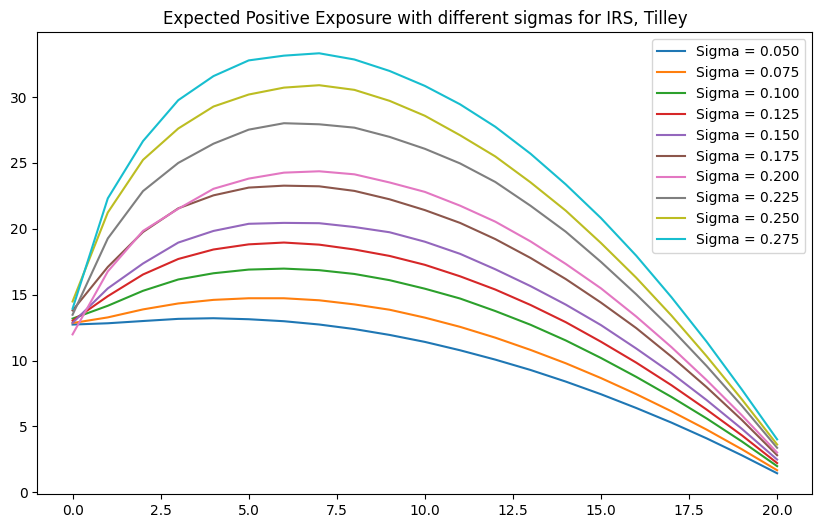

In [ ]:
SIG = np.linspace(0.05, 0.275, 10)
def RysExposureSwapSigmaTilley(Sigma = SIG, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040, Q = 80,  Strike = 0.05):
  plt.figure(figsize = (10,6))
  for sigma in SIG:
    Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()
    # p, W = Tsitsiklis(T, n, M, Q, r, sigma, S0, Strike).AmericanPutOptionMod(Dynamic)
    # V1 = np.zeros(n)

    W2 = Tilley(T, n, M, Q, r, sigma, S0, Strike).ValueSwap(Dynamic, 4, "receiver", 1000)
    V2 = np.zeros(n)

    for i in range(n):
      V2[i] = np.mean(np.maximum(W2[:, i], 0))#nominale
    plt.plot(V2, label = f"Sigma = {sigma:.3f}")
  plt.title("Expected Positive Exposure with different sigmas for IRS, Tilley")
  plt.legend()
  plt.show()
RysExposureSwapSigmaTilley()

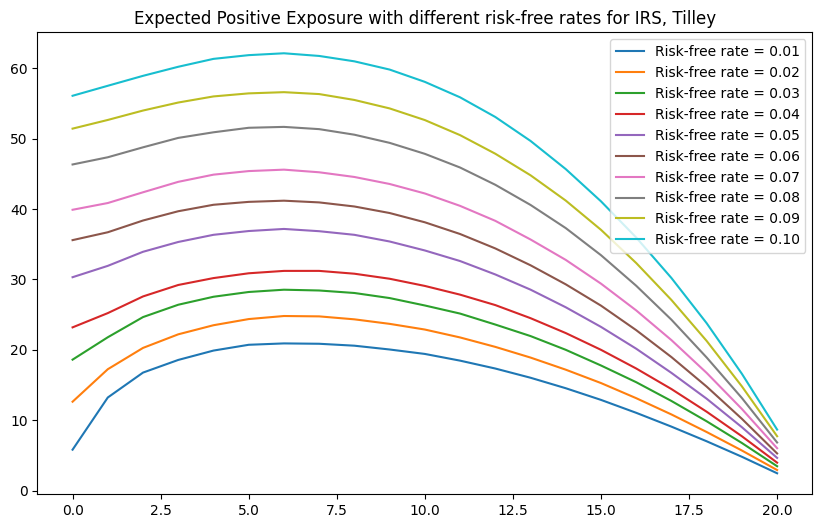

In [ ]:
R = np.linspace(0.01, 0.1, 10)
def RysExposureSwapRatesTilley(Sigma = 0.2, r = R, T = 5.0, S0 = 0.05, n = 21, M = 5040, Q = 80,  Strike = 0.05):
  plt.figure(figsize = (10,6))
  for r in R:
    Dynamic = Market(T, n, M, Q, r, Sigma, S0, Strike).BSDynamic()
    # p, W = Tsitsiklis(T, n, M, Q, r, sigma, S0, Strike).AmericanPutOptionMod(Dynamic)
    # V1 = np.zeros(n)

    W2 = Tilley(T, n, M, Q, r, Sigma, S0, Strike).ValueSwap(Dynamic, 4, "receiver", 1000)
    V2 = np.zeros(n)

    for i in range(n):
      V2[i] = np.mean(np.maximum(W2[:, i], 0))#nominale
    plt.plot(V2, label = f"Risk-free rate = {r:.2f}")
  plt.title("Expected Positive Exposure with different risk-free rates for IRS, Tilley")
  plt.legend()
  plt.show()
RysExposureSwapRatesTilley()

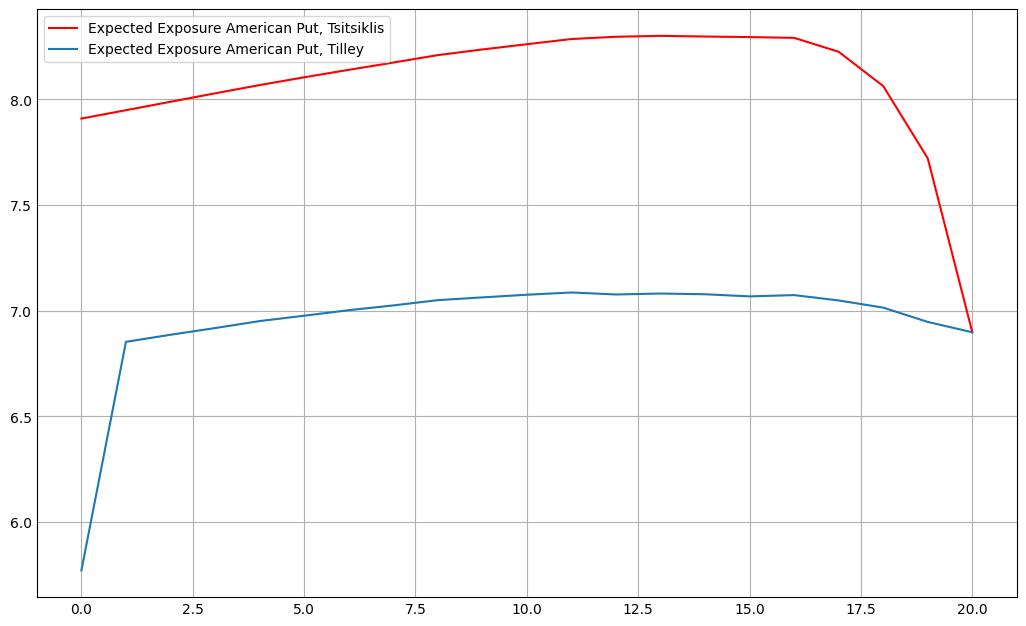

In [ ]:
def RysExposure(sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040*4, Q = 80*2,  Strike = 0.05 ):

  Dynamic = Market(T, n, M, Q, r, sigma, S0, Strike).BSDynamic()
  p, W = Tsitsiklis(T, n, M, Q, r, sigma, S0, Strike).AmericanPutOptionMod(Dynamic)
  V1 = np.zeros(n)

  _, W2 = Tilley(T, n, M, Q, r, sigma, S0, Strike).Price(Dynamic)
  V2 = np.zeros(n)

  for i in range(n):
    V1[i] = np.mean(W[:, i])*1000 #nominale
    V2[i] = np.mean(W2[:, i])*1000
  plt.figure(figsize = (10,6))
  plt.plot(V1, label = "Expected Exposure American Put, Tsitsiklis", color = "red")
  plt.plot(V2, label = "Expected Exposure American Put, Tilley")
  plt.legend()
  plt.show()

RysExposure()

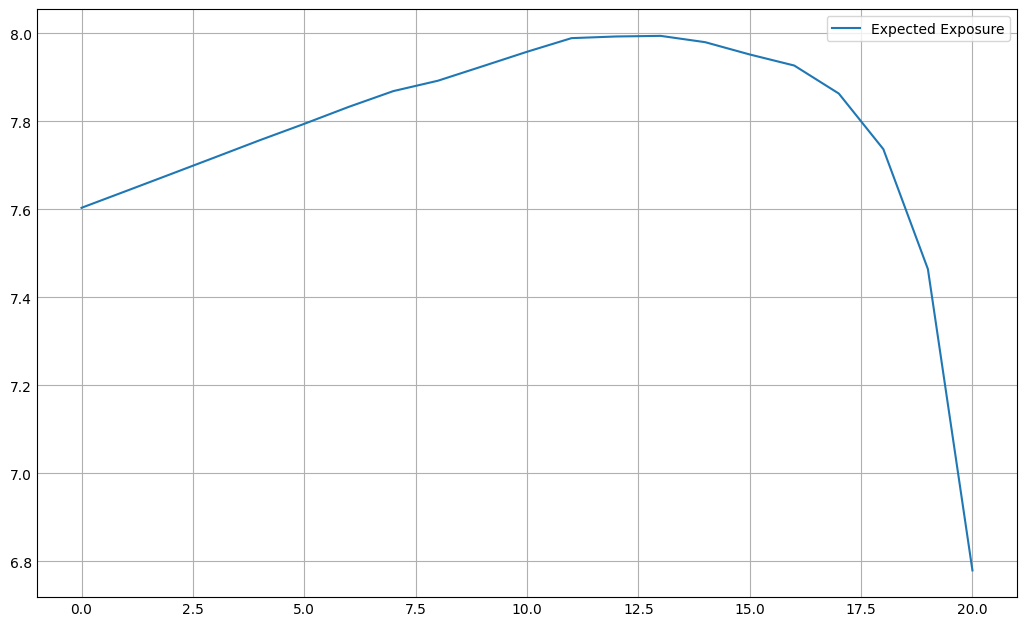

In [ ]:
def RysTsitsiklisExposure(sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040, Strike = 0.05):

  Dynamic = Market(T, n, M, 1, r, sigma, S0, Strike).BSDynamic()
  p, W = Tsitsiklis(T, n, M, 1, r, sigma, S0, Strike).AmericanPutOptionMod(Dynamic)
  V1 = np.zeros(n)

  for i in range(n):
    V1[i] = np.mean(W[:, i])*1000 #nominale
  plt.figure(figsize = (10,6))
  plt.plot(V1, label = "Expected Exposure")
  plt.legend()
  plt.show()

RysTsitsiklisExposure()

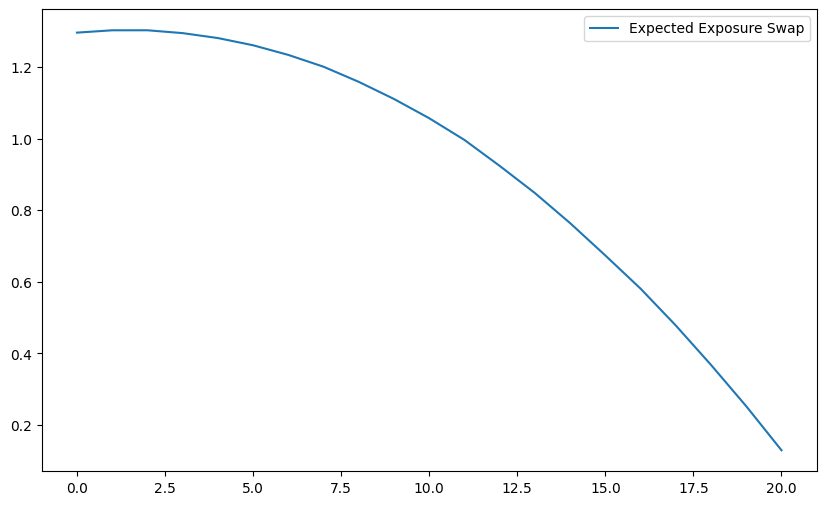

In [ ]:
def RysTsitsiklisExposureSwap(sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040, Strike = 0.05):
  Dynamic = Market(T, n, M, 1, r, sigma, S0, Strike).BSDynamic()
  p, W = Tsitsiklis(T, n, M, 1, r, sigma, S0, Strike).SwapPrice(Dynamic, 4, "receiver", 100)
  V1 = np.zeros(n)

  for i in range(n):
    V1[i] = np.mean(W[:, i]) #nominale
  plt.figure(figsize = (10,6))
  plt.plot(V1, label = "Expected Exposure Swap")
  plt.legend()
  plt.show()
RysTsitsiklisExposureSwap()

In [ ]:
qwe = Tsitsiklis(1,10,100000, 1,0.03,0.2,100,100).AmericanPutOption(Market(1,10,100000,1,0.03,0.2,100,100).BSDynamic())
print(qwe)
# qwe2 = pd.DataFrame(data = Tsitsiklis(1,10,100000, 1,0.03,0.2,100,100).AmericanPutOptionMod(Market(1,10,100000,1,0.03,0.2,100,100).BSDynamic()))
qwe2,_ = Tsitsiklis(1,10,100000, 1,0.03,0.2,100,100).AmericanPutOptionMod(Market(1,10,100000,1,0.03,0.2,100,100).BSDynamic())
print(qwe2)

6.198652173336884
7.184370027583366


In [ ]:
swapPrice = Tsitsiklis(1,10,1000,40,0.03,0.2,0.03,0.05).SwapPrice(Market(1,10,1000,40,0.03,0.2,0.03, 0.05).BSDynamic(), 4, "receiver", 100)
print(swapPrice)

-2.4069384705793677


In [ ]:
import random

In [ ]:
QBig = [20, 21, 24, 28, 30, 35, 36, 40, 42, 45, 48, 56, 60, 63, 70, 72, 80, 84, 90, 105, 112, 120, 126, 140, 144, 168, 180, 210, 240, 252, 280, 315, 336, 360, 420, 504]

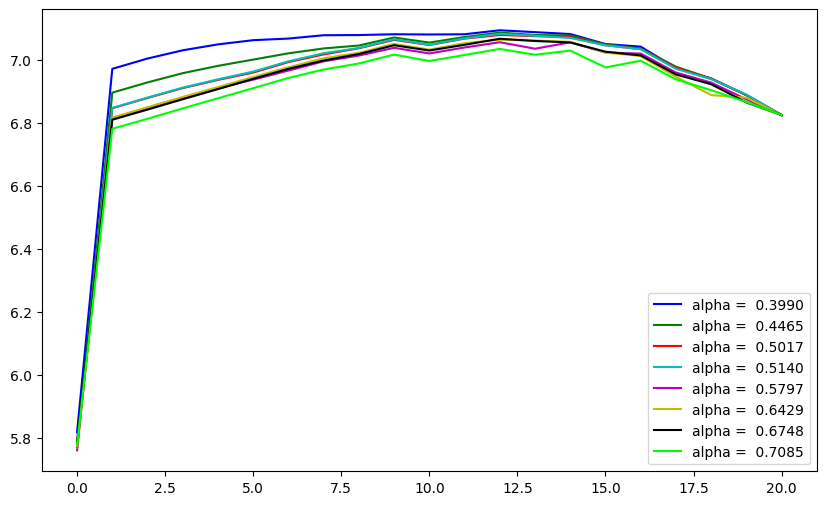

In [ ]:
QBig = [30, 45, 72, 80, 140, 240, 315, 420]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#00FF00']
def Rysunek1(Q = [i for i in QBig], sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040, Strike = 0.05):
  plt.figure(figsize = (10,6))
  Dynamic = Market(T, n, M, 1, r, sigma, S0, Strike).BSDynamic()
  k = 0
  for q in Q:
    # np.random.seed(10)
    alpha = np.log(q)/ np.log(M)
    # V,_,_, _ = Tilley(T, n, M, q, r, sigma, S0, Strike).Value(Dynamic)
    _, V = Tilley(T, n, M, q, r, sigma, S0, Strike).Price(Dynamic)
    V1 = np.zeros(n)
    # V1[0] = Tilley(T, n, M, q, r, sigma, S0, Strike).Price(Market(T, n, M, q, r, sigma, S0, Strike).BSDynamic())
    for i in range(n):
      V1[i] = np.mean(V[:, i])*1000 #nominale

    plt.plot(V1, label = f'alpha =  {alpha:,.4f}', color = colors[k])
    k += 1
  plt.legend()
  plt.show()

Rysunek1()

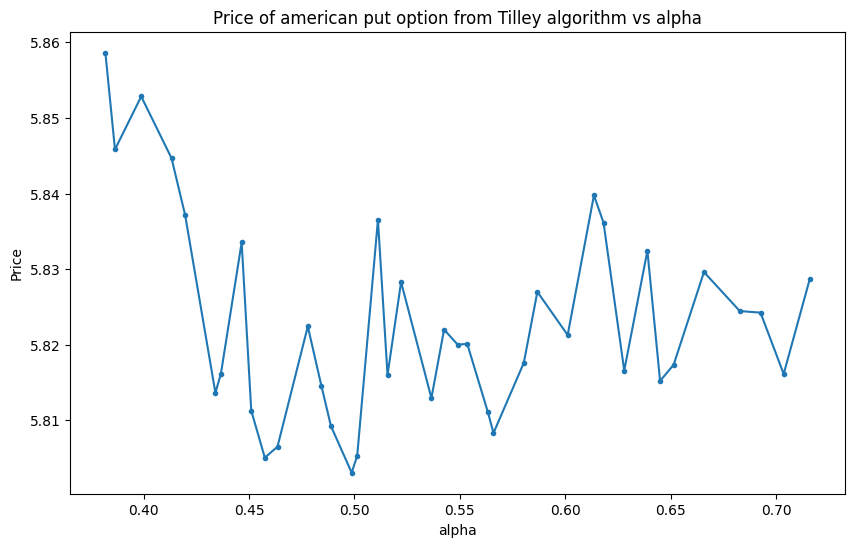

In [ ]:
QBig = [20, 21, 24, 28, 30, 35, 36, 40, 42, 45, 48, 56, 60, 63, 70, 72, 80, 84, 90, 105, 112, 120, 126, 140, 144, 168, 180, 210, 240, 252, 280, 315, 336, 360, 420, 504, 560, 630, 720]  #do 5040
def Rysunek2(Q = [i*3 for i in QBig], sigma = 0.2, r = 0.02, T = 5.0, S0 = 0.05, n = 21, M = 5040*9, Strike = 0.05):
  Cena = np.zeros(len(Q))
  alpha = np.zeros(len(Q))
  Dynamic = Market(T, n, M, 1, r, sigma, S0, Strike).BSDynamic()
  i = 0
  for q in Q:
    alpha[i] = np.log(q)/ np.log(M)
    Cena[i], a = Tilley(T, n, M, q, r, sigma, S0, Strike).Price(Dynamic)
    Cena[i] = Cena[i]*1000
    i += 1
  plt.figure(figsize=(10,6))
  plt.plot(alpha, Cena, marker = ".")
  plt.xlabel('alpha')
  plt.ylabel('Price')
  plt.title("Price of american put option from Tilley algorithm vs alpha")
  plt.show()

Rysunek2()

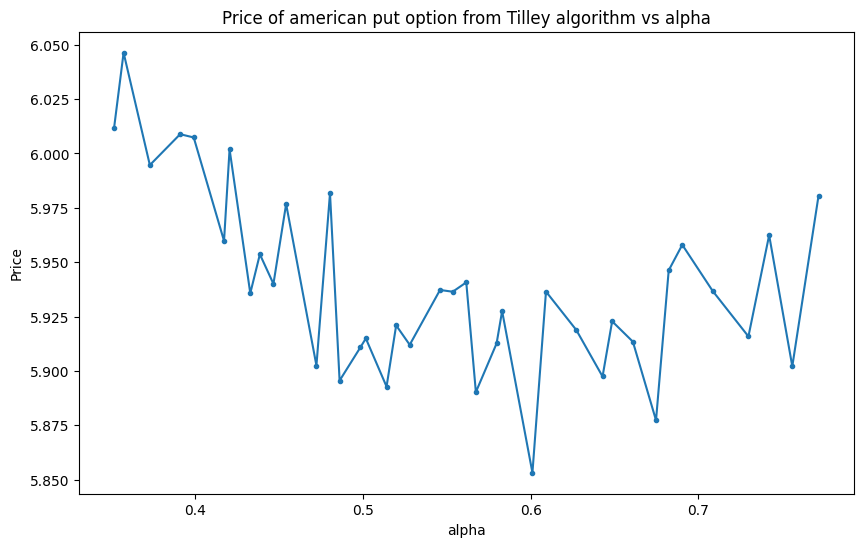

In [ ]:
Rysunek2()